# XGBOOST

## XGBoost Modeling and Analysis

### This file is a pipeline of XGBoost modeling.
The Pipeline will be as follows:

1. Read the data in with custom function built at the end of the `Baseball_EDA` notebook.
2. Build a Pipeline object with two components: a random undersampler and the classification model. Random Undersampler was chosen due to imbalance of the target classes. 
3. Fit the pipeline to training data and verify results using 5-fold cross validation. This process will use custom function in the `Evaluation.py` module.  
4. Tune the hyperparameters using Bayesian Optimization with 'skopt' library. 

In [ ]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
from data_import import prepare_data
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import xgboost as xgb

In [ ]:
#Read in the data as pandas dataframe
file = '../Statcast_data.csv'

#define bsb as the full dataframe
bsb = prepare_data('../Statcast_data.csv')

#filter out the predictors and the target
X = bsb.drop(columns = ['player_name', 'description'])
y = bsb['description']

#quick look to see above worked. 
X.head()



,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,vx0,vz0,vy0,sz_top,sz_bot,pitch_L,pitch_R,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,2314.0,3.2655,54.4995,5.2575,-9.8035,0.1339,-138.1130,3.2971,1.5059,1,0,1,0,0,0,0,0,0,0
1,2324.0,3.1728,54.3094,5.3966,-9.0084,-2.4218,-140.5865,3.3136,1.5730,1,0,0,1,0,0,0,0,0,0
2,2521.0,3.3517,55.0820,5.1205,-3.7285,1.2140,-117.3223,3.9119,1.7080,1,0,0,0,0,0,0,0,1,0
3,2329.0,3.1334,54.0207,5.2136,-12.0533,-5.1407,-139.3669,3.5553,1.5639,1,0,0,1,0,0,0,0,0,0
4,2437.0,3.3033,54.3597,5.0589,-14.0287,-3.3434,-139.8559,3.3450,1.6241,1,0,0,1,0,0,0,0,0,0


# XGBoost

In [ ]:
#split the data into training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state = 777)

#build the pipeline object
#use a vanilla XGBoost Classifier
XGB = xgb.XGBClassifier()
sampler = RandomUnderSampler(ratio = 1, random_state=777)

xgb_pipe = Pipeline(steps = [
    ("sampler", sampler),
     ('xgb', XGB)])

xgb_pipe_results = cross_validate(xgb_pipe, X_train, y_train, 
                            scoring = ['accuracy', 'f1', 'roc_auc'], 
                            cv =5, return_estimator=True, return_train_score = True)

for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
    print(f"Mean {result} Value: {np.mean(xgb_pipe_results[result])}")
    print(f"{result} scores: {xgb_pipe_results[result]}")
    print() 

Mean train_accuracy Value: 0.6928996176892199
train_accuracy scores: [0.6963001  0.69110865 0.695022   0.69102959 0.69103774]

Mean test_accuracy Value: 0.6851626184158127
test_accuracy scores: [0.68541162 0.68288184 0.68725625 0.68145884 0.68880455]

Mean train_f1 Value: 0.6352614631922883
train_f1 scores: [0.63733774 0.63477028 0.63580577 0.63489295 0.63350057]

Mean test_f1 Value: 0.6257969601717097
test_f1 scores: [0.6234307  0.62564549 0.62533148 0.62585118 0.62872595]

Mean train_roc_auc Value: 0.7987841274871798
train_roc_auc scores: [0.79984129 0.79645041 0.800181   0.79962628 0.79782166]

Mean test_roc_auc Value: 0.7874905608181912
test_roc_auc scores: [0.78134095 0.79045872 0.78552407 0.78458182 0.79554726]



In [ ]:
predictions = xgb_pipe_results['estimator'][0].predict(X_test)

eval_test_set(predictions, y_test)



Accuracy Score: 0.6879486449735952

AUC Score: 0.7231291993275497

F1 Score: 0.6292177049673104

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.62      0.73     21437
           1       0.51      0.82      0.63     10186

   micro avg       0.69      0.69      0.69     31623
   macro avg       0.70      0.72      0.68     31623
weighted avg       0.76      0.69      0.70     31623


 Confustion Matrix: 
 [[13382  8055]
 [ 1813  8373]]


In [ ]:
from skopt import BayesSearchCV

ITERATIONS = 50
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb_pipe,
    search_spaces = {
        'xgb__learning_rate': (0.01, 1.0, 'log-uniform'),
        'xgb__min_child_weight': (0, 10),
        'xgb__max_depth': (1, 50),
        'xgb__max_delta_step': (0, 20),
        'xgb__subsample': (0.01, 1.0, 'uniform'),
        'xgb__colsample_bytree': (0.01, 1.0, 'uniform'),
        'xgb__colsample_bylevel': (0.01, 1.0, 'uniform'),
        'xgb__reg_lambda': (1e-9, 1000, 'log-uniform'),
        'xgb__reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'xgb__gamma': (1e-9, 0.5, 'log-uniform'),
        'xgb__min_child_weight': (0, 5),
        'xgb__n_estimators': (50, 100),
        'xgb__scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 2019
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

In [ ]:
result = bayes_cv_tuner.fit(X_test, y_test, callback=status_print)

Model #1
Best ROC-AUC: 0.0
Best params: {'xgb__colsample_bylevel': 0.6209161581689696, 'xgb__colsample_bytree': 0.9543275764819017, 'xgb__gamma': 0.019306137883859383, 'xgb__learning_rate': 0.03133533072824358, 'xgb__max_delta_step': 1, 'xgb__max_depth': 11, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 57, 'xgb__reg_alpha': 0.00031596262458470826, 'xgb__reg_lambda': 0.18102189707922706, 'xgb__scale_pos_weight': 0.02920585956428371, 'xgb__subsample': 0.5387531676662357}

Model #2
Best ROC-AUC: 0.4945
Best params: {'xgb__colsample_bylevel': 0.5708090752014388, 'xgb__colsample_bytree': 0.29151890296236854, 'xgb__gamma': 3.2614413979366036e-09, 'xgb__learning_rate': 0.45037921115768326, 'xgb__max_delta_step': 20, 'xgb__max_depth': 9, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 79, 'xgb__reg_alpha': 7.133539629535907e-08, 'xgb__reg_lambda': 1.476688415636138e-07, 'xgb__scale_pos_weight': 23.669853155636478, 'xgb__subsample': 0.05948834424298481}

Model #3
Best ROC-AUC: 0.4945
Best 

In [ ]:
xgb_best = result.best_estimator_

predictions = xgb_best.predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"AUC Score: {metrics.roc_auc_score(y_test, x_test_predictions)}")
    print()
    print(f"F1 Score: {metrics.f1_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)

Accuracy Score: 0.9034563450653006

AUC Score: 0.9287913420721183

F1 Score: 0.8696691568836713

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     21437
           1       0.77      1.00      0.87     10186

   micro avg       0.90      0.90      0.90     31623
   macro avg       0.88      0.93      0.90     31623
weighted avg       0.93      0.90      0.91     31623


 Confustion Matrix: 
 [[18384  3053]
 [    0 10186]]


In [ ]:
from sklearn.externals import joblib

filename = '../Models/XGB_tuned.sav'
joblib.dump(xgb_best, filename)

['../Models/XGB_tuned.sav']

# Feature Importances

<Figure size 432x288 with 0 Axes>

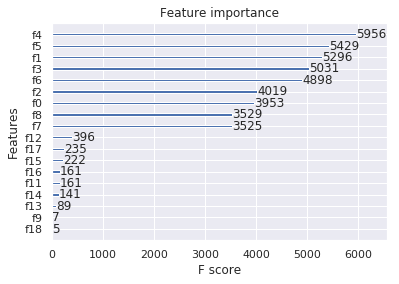

In [ ]:
xgb_best_model = xgb_best.steps[1][1]

fig = plt.figure()
ax = xgb.plot_importance(xgb_best_model)
fig.savefig('../images/XGB_tuned_feat_import.png')

### Feature Mapping:
- f0: release_spin_rate
- f1: release_pos_x
- f2: release_pos_y
- f3: release_pos_z
- f4: vx0
- f5: vz0
- f6: vy0
- f7: sz_top
- f8: sz_bot
- f9: pitch_L
- f10: pitch_R
- f11: pitch_2-Seam Fastball
- f12: pitch_4-Seam Fastball
- f13: pitch_Changeup
- f14: pitch_Curveball
- f15: pitch_Cutter
- f16: pitch_Sinker
- f17: pitch_Slider
- f18: pitch_Split Finger


